## Prepearation

In [0]:
# !git remote add origin https://github.com/lironsoffer/CausalInference.git
# !git push -u origin master

In [0]:
# !pip install bootstrapped
!pip install --upgrade pandas

### Imports and Setup

In [0]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn import svm
# from sklearn import tree
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import linear_model
import copy
from scipy import stats
# import bootstrapped.bootstrap as bs
# import bootstrapped.stats_functions as bs_stats
import random
import math

seed = 666

In [0]:
drive.mount('/content/gdrive')
# !mkdir -p 'gdrive/My Drive/Colab Notebooks/Causal Inference/hw3'
print(os.chdir('gdrive/My Drive/Colab Notebooks/Causal Inference/project'))
print(os.listdir())

### Loading and Setting up the raw data

In [0]:
PATH = Path('')
data1_path = PATH/'flavors_of_cacao.csv'
paths = {'data':data1_path}

In [0]:
def save_df(df,path=None):
  if isinstance(path, str): path = paths[path]
  df.to_csv(path, sep=',', encoding="utf-8-sig", index=False)

def load_df(path):
  return pd.read_csv(path, sep=',', encoding="utf-8-sig")

# return df.iloc[:,1:]

In [0]:
data = load_df(data1_path)

In [8]:
# data.head()
data.columns

Index(['Company \n(Maker-if known)', 'Specific Bean Origin\nor Bar Name',
       'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')

In [9]:
mapper = {'Company  (Maker-if known)':'company', 'Specific Bean Origin\nor Bar Name':'origin',
       'REF':'REF', 'Review\nDate':'date', 'Cocoa\nPercent':'cocoa', 'Company\nLocation':'location', 'Rating':'rating',
       'Bean\nType':'bean', 'Broad Bean\nOrigin':'broad_origin'}
data.rename(mapper=mapper,axis='columns',inplace='True')
data.rename(columns={data.columns[0]:'company'},inplace='True')

data.head()

,company,origin,REF,date,cocoa,location,rating,bean,broad_origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [10]:
data.columns

Index(['company', 'origin', 'REF', 'date', 'cocoa', 'location', 'rating',
       'bean', 'broad_origin'],
      dtype='object')

cocoa

In [0]:
data.cocoa = data.cocoa.apply(lambda x: float(x.strip('%')))
data.drop(data[data.cocoa<50].index,inplace=True)
data.reset_index(drop=True,inplace=True)
cocoa_raw = data.cocoa

In [12]:
bins = pd.IntervalIndex.from_tuples([(59,68),(68,71),(71,75),(75,85)])
bins_list = bins.to_series().astype(str)
cocoa = pd.cut(cocoa_raw, bins=bins, labels=False)
data.drop(data[cocoa.isna()].index,inplace=True)
cocoa_raw = data.cocoa
cocoa.value_counts()

(68, 71]    713
(71, 75]    507
(59, 68]    287
(75, 85]    212
Name: cocoa, dtype: int64

### get dummies for columns

company

In [0]:
condition = data.company.value_counts()>5
# condition[condition].index
company = data.company.apply(lambda x: x if x in condition[condition].index else 'other')
company_dummies = pd.get_dummies(data=company,prefix='company')
# company.value_counts()

origin

In [0]:
condition = data.origin.value_counts()>5
origin = data.origin.apply(lambda x: x if x in condition[condition].index else 'other')
origin_dummies = pd.get_dummies(data=origin,prefix='origin')
# origin.value_counts()

broad origin

In [0]:
# broad_origin = data.broad_origin.apply(lambda x: 'other' if x=='' else x)
condition = data.broad_origin.value_counts()>5
broad_origin = data.broad_origin.apply(lambda x: x if x in condition[condition].index else 'other')
if broad_origin.value_counts().index[6]!='other': broad_origin.replace(broad_origin.value_counts().index[6],'other',inplace=True)
broad_origin_dummies = pd.get_dummies(data=broad_origin,prefix='broad_origin')
# broad_origin.value_counts()

bean

In [0]:
condition = data.bean.value_counts()>5
bean = data.bean.apply(lambda x: x if x in condition[condition].index else 'other')
if bean.value_counts().index[0]!='Other': bean.replace(bean.value_counts().index[0],'other',inplace=True)
bean_dummies = pd.get_dummies(data=bean,prefix='bean')
# bean.value_counts()

date

In [0]:
condition = data.date.value_counts()>5
date = data.date.apply(lambda x: x if x in condition[condition].index else 'other')
date_dummies = pd.get_dummies(data=date,prefix='date')
# date.value_counts()

location

In [0]:
condition = data.location.value_counts()>5
location = data.location.apply(lambda x: x if x in condition[condition].index else 'other')
location_dummies = pd.get_dummies(data=location,prefix='location')
# location.value_counts()

ratings

In [19]:
data.rating.value_counts()

3.50    385
3.00    329
3.25    289
2.75    244
3.75    208
2.50    119
4.00     97
2.00     25
2.25     12
1.50      5
1.00      3
5.00      2
1.75      1
Name: rating, dtype: int64

### constructing the df - NOTICE: df contains the dummies and the ratings while data contains the raw data. df DOES NOT contain the treatment (cocoa %)

In [20]:
df = pd.concat([company_dummies, origin_dummies, date_dummies, location_dummies, bean_dummies, broad_origin_dummies, data.rating], axis=1)
# df.head()
# len(df)
df.columns

Index(['company_A. Morin', 'company_Altus aka Cao Artisan', 'company_Amano',
       'company_Ambrosia', 'company_Amedei', 'company_Arete',
       'company_Artisan du Chocolat', 'company_Askinosie',
       'company_Benoit Nihant', 'company_Beschle (Felchlin)',
       ...
       'broad_origin_Sao Tome & Principe', 'broad_origin_St. Lucia',
       'broad_origin_Tanzania', 'broad_origin_Trinidad', 'broad_origin_Uganda',
       'broad_origin_Vanuatu', 'broad_origin_Venezuela',
       'broad_origin_Vietnam', 'broad_origin_other', 'rating'],
      dtype='object', length=223)

### Visuallizing Treatment and Outcome

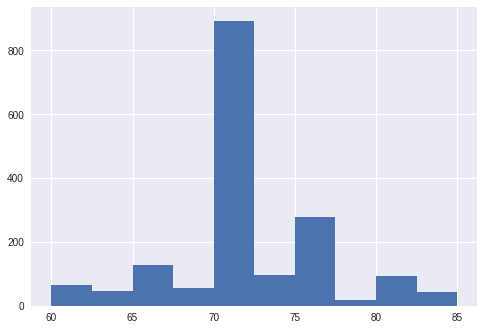

In [21]:
hist = cocoa_raw.hist(bins=10)

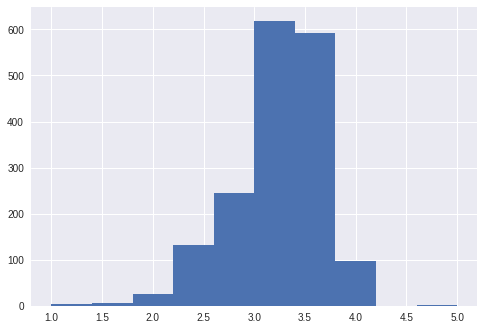

In [22]:
rating_hist = data.rating.hist(bins=10)

**Naive avarage rating by cocoa %**

In [23]:
print("avarage rating by cocoa %\n")
df_dict = {}
for k in bins_list:
  df_dict[k] = data[cocoa.astype(str)==k].rating
  print(k, round(df_dict[k].mean(), 2))

avarage rating by cocoa %

(59, 68] nan
(68, 71] nan
(71, 75] nan
(75, 85] nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff036a92cf8>,
      dtype=object)

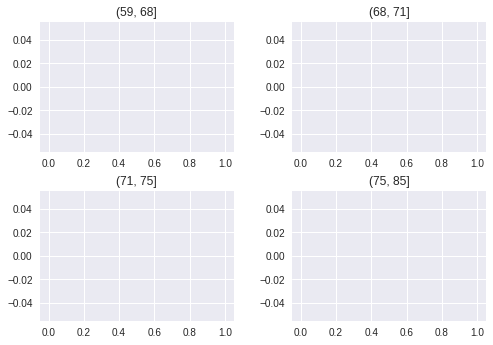

In [24]:
tmp_df = pd.DataFrame(df_dict)
tmp_df.hist(bins=7)

## IPW

Notice that unlike IPW we used in class, here we use multi-class classification.

Thereby, predict_proba returns a vector of probabilities.

In [0]:
from sklearn.metrics import mean_squared_error, balanced_accuracy_score, accuracy_score, f1_score
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [0]:
X,T = df.drop(['rating'],axis=1), cocoa_raw.astype('int')
X_train, X_test, T_train, T_test = train_test_split(X,T,test_size=0.2,shuffle=False)

### Propensity Score - accessing the treatment probability (cocoa % prediction)

**Classification**

Prediting the treatment (cocoa %) is approached as a classification problem since we are interested in the probabilities of each treatment.

In [28]:
# Classification
T_train_str = pd.cut(pd.Series(T_train), bins=bins).astype('str').dropna()
T_test_str = pd.cut(T_test, bins=bins, labels=False).astype('str').dropna()

classifier = {}
classifier['LogisticRegression'] = LogisticRegression(solver='newton-cg', multi_class='auto').fit(X_train,T_train_str)

T_pred_classification = {}
acc_classification = {}
for k in classifier:
  T_pred_classification[k] = classifier[k].predict(X_test)
  acc_classification[k] = accuracy_score(T_pred_classification[k],T_test_str)
  
print("\nPrediction of T - cocoa %\n")
for k in classifier:
  print("{} Accuracy = {:.2f}".format(k,acc_classification[k]))
print('\n')


Prediction of T - cocoa %

LogisticRegression Accuracy = 0.40




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0358faba8>,
      dtype=object)

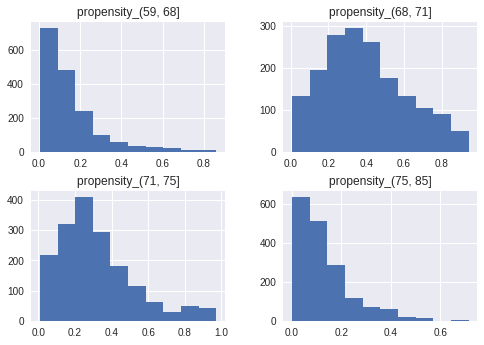

In [29]:
best_clf = classifier['LogisticRegression']

def calc_propensity_vec(X, best_clf=best_clf):
#   print("calculating propensity vector..")
  
  X.fillna(0,inplace=True)
  propensity_vec = pd.DataFrame(best_clf.predict_proba(X.values),columns=['propensity_{}'.format(b) for b in bins_list])
  propensity_log_vec = pd.DataFrame(best_clf.predict_log_proba(X.values),columns=['propensity_{}'.format(b) for b in bins_list])

  propensity_sum_weights = (1/propensity_vec).sum()
  
#   print("done")
  
  return propensity_vec, propensity_sum_weights

population_propensity_vec, population_propensity_sum_weights = calc_propensity_vec(X)
population_propensity_vec.hist()

In [30]:
# Classification
T_train_str = pd.cut(pd.Series(T_train), bins=bins).astype('str').dropna()
T_test_str = pd.cut(T_test, bins=bins, labels=False).astype('str').dropna()

classifier = {}
classifier['LogisticRegression'] = LogisticRegression(solver='newton-cg', multi_class='auto').fit(X_train,T_train_str)

T_pred_classification = {}
acc_classification = {}
for k in classifier:
  T_pred_classification[k] = classifier[k].predict(X_test)
  acc_classification[k] = accuracy_score(T_pred_classification[k],T_test_str)
  
print("\nPrediction of T - cocoa %\n")
for k in classifier:
  print("{} Accuracy = {:.2f}".format(k,acc_classification[k]))
print('\n')


Prediction of T - cocoa %

LogisticRegression Accuracy = 0.40




In [31]:
(1/population_propensity_vec).describe().round(3)

,"propensity_(59, 68]","propensity_(68, 71]","propensity_(71, 75]","propensity_(75, 85]"
count,1719.000,1719.000,1719.000,1719.000
mean,14.234,4.776,5.831,16.815
std,16.826,8.199,8.516,23.573
min,1.162,1.061,1.029,1.400
25%,4.933,1.861,2.389,5.785
50%,9.249,2.753,3.649,9.983
75%,16.859,4.413,5.846,18.599
max,216.061,124.858,110.105,475.167


### Possible Outcomes (rating) Prediction

Fitting the model is done with the real treatment. Later on all possible outcomes are calculated with artificial treatment attached.

**Fitting the model:**

In [32]:
# Regerssion
Y = df.rating
T_dummies = pd.get_dummies(pd.cut(T, bins=bins, labels=False))
X2 = pd.concat([X,T_dummies],axis=1)
X2_train, X2_test, Y_train, Y_test = train_test_split(X2,Y,test_size=0.1,shuffle=False)

rating_regressor = DecisionTreeRegressor().fit(X2_train,Y_train)
Y_pred = rating_regressor.predict(X2_test)
mse = mean_squared_error(Y_pred,Y_test)
print("{:.2f}".format(mse))

0.32


**Constructing the artificial DataFrames:**

In [0]:
bins_list = bins.to_series().astype(str)
cocoa_cols = ['cocoa_{}'.format(b) for b in bins_list]

In [0]:
def predict_for_samples(samples):
#   print("predicting for sample")
  zeros_arr = np.ndarray([len(samples), len(cocoa_cols)],dtype='int') * 0

  T_art_dummies = {}
  for i,b in enumerate(bins_list):
    T_art_dummies[b] = pd.DataFrame(zeros_arr,columns=cocoa_cols).copy()
    T_art_dummies[b].iloc[:,i] = 1
  
  X_art = {}
  Y_pred_art = {}
  for b in bins_list:
#     print(np.any(np.isnan(samples)),np.any(np.isnan(T_art_dummies[b])))
    X_art[b] = samples.reset_index(drop=True).join([T_art_dummies[b].reset_index(drop=True)], how='left')
#     X_art[b] = pd.concat([samples,T_art_dummies[b]],axis=1)
    X_art[b].fillna(0,inplace=True)
    Y_pred_art[b] = rating_regressor.predict(X_art[b])
#   print("done")
  return X_art, Y_pred_art

In [0]:
def IPW(samples):
  IPW_samples_df = pd.DataFrame()
  IPW_sum = {}
  X_art, Y_pred_art = predict_for_samples(samples)
  propensity_vec, propensity_sum_weights = calc_propensity_vec(samples)
#   print("calculating IPW..")
  for b in bins_list:
    IPW_samples_df['IPW_{}'.format(b)] = 0
    IPW_samples_df['IPW_{}'.format(b)] = Y_pred_art[b]/propensity_vec['propensity_{}'.format(b)]
    
    sum_func = lambda x: IPW_samples_df['IPW_{}'.format(b)].sum()/propensity_sum_weights['propensity_{}'.format(b)]
        
    IPW_sum[b] = IPW_samples_df['IPW_{}'.format(b)].sum()/propensity_sum_weights['propensity_{}'.format(b)]
  return IPW_sum

In [0]:
n_samples = 1000
trim_proportiontocut = 0.2
def IPW_print():
  population = X.copy()
#   samples = [train_test_split(population,train_size=0.8)[0]]
  def gen_sample():
    indecs = sorted([random.randint(0, len(population)-1) for i in range(1000)])
    smp = population.iloc[indecs]
    return smp
  samples = [gen_sample() for i in range(n_samples)]
  print("bootstrapping {} times.. it might take a minute".format(n_samples))
  bootstrap = [IPW(sample) for sample in samples]
  
  bootstrap_df = pd.DataFrame(bootstrap)
  bootstrapped_avg = dict(bootstrap_df.apply(lambda x: stats.trim_mean(x,trim_proportiontocut),axis=0))
  bootstrapped_std = dict(bootstrap_df.apply(lambda x: np.std(x),axis=0))

#   bootstrapped_std = bootstrap_df.apply(np.std)


  print("IPW avarage rating by cocoa % \nbootstrapped {} times, trimmed with proportiontocut {}:".format(n_samples,trim_proportiontocut))
  for k in bootstrapped_avg:
      print("{} {:.2f} ,std={:.2f}".format(k, bootstrapped_avg[k], bootstrapped_std[k]))

  print("\nIPW ATE between each group of cocoa % and its following:")
  IPW_sum_list = list(bootstrapped_avg.items())
  for i in range(len(IPW_sum_list)-1):
    print("IPW{}-IPW{} = {:.2f}".format(IPW_sum_list[i+1][0],IPW_sum_list[i][0],IPW_sum_list[i+1][1]-IPW_sum_list[i][1]))
  print('\n\n')
  return bootstrap 

In [44]:
pd.options.mode.chained_assignment = None
IPW_dict = IPW_print()

bootstrapping 1000 times.. it might take a minute
IPW avarage rating by cocoa % 
bootstrapped 1000 times, trimmed with proportiontocut 0.2:
(59, 68] 3.26 ,std=0.02
(68, 71] 3.26 ,std=0.03
(71, 75] 3.16 ,std=0.02
(75, 85] 3.24 ,std=0.03

IPW ATE between each group of cocoa % and its following:
IPW(68, 71]-IPW(59, 68] = -0.00
IPW(71, 75]-IPW(68, 71] = -0.10
IPW(75, 85]-IPW(71, 75] = 0.09



